In [32]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import plotly.express as px
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import warnings
import xgboost as xgb
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_excel('/Users/joaosequeira/sao_paulo_apartments/sao_paulo_apartments/dados_wgs.xlsx')
df


In [5]:
treated_df = df[['valor_total', 'unit', 'area_util', 'quartos', 'vagas',
       'condominio', 'suites', 'banheiros', 'piscina', 'academia', 'quadra',
       'media_idh', 'media_gini', 'expectativa_vida', 'renda_percapita',
        'dist', 'lat', 'lon']]

treated_df.isnull().sum()

valor_total           0
unit                  0
area_util             0
quartos               0
vagas                 0
condominio          235
suites                0
banheiros             0
piscina               0
academia              0
quadra                0
media_idh             0
media_gini            0
expectativa_vida      0
renda_percapita       0
dist                  0
lat                   0
lon                   0
dtype: int64

In [6]:
treated_df = treated_df.fillna(0)

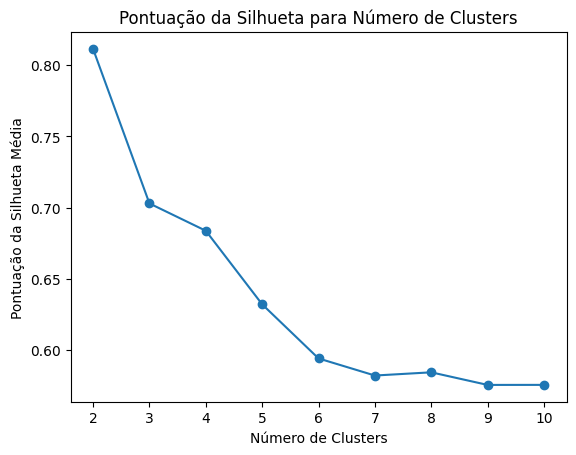

In [22]:
# Definir uma lista de número de clusters para testar
num_clusters = range(2, 11)

# Lista para armazenar os valores de silhueta média para cada número de clusters
silhouette_scores = []

# Executar o K-means para cada número de clusters e calcular a silhueta
for num in num_clusters:
    kmeans = KMeans(n_clusters=num, random_state=42)
    cluster_labels = kmeans.fit_predict(treated_df)
    silhouette_avg = silhouette_score(treated_df, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plotar o gráfico de silhueta
plt.plot(num_clusters, silhouette_scores, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Pontuação da Silhueta Média')
plt.title('Pontuação da Silhueta para Número de Clusters')
plt.show()

In [18]:
#instantiate the k-means class, using optimal number of clusters
kmeans = KMeans(init="random", n_clusters=2, n_init=10, random_state=1)

#fit k-means algorithm to data
kmeans.fit(treated_df)

#view cluster assignments for each observation
treated_df['cluster'] = kmeans.labels_


In [19]:
# Criar o boxplot com o Plotly
fig = px.box(df, x=treated_df['cluster'], y=treated_df['media_idh'])

# Exibir o gráfico
fig.show()

In [25]:
fig = px.scatter_mapbox(treated_df, lat='lat', lon='lon', color='cluster', 
                        color_continuous_scale='Viridis', opacity=1)

# Configurar o mapa
fig.update_layout(mapbox_style='open-street-map')
fig.update_layout(margin={'l': 0, 'r': 0, 't': 0, 'b': 0})

# Exibir o gráfico
fig.show()

In [34]:

def create_cluster_histogram(variable, df=treated_df, cluster_column='cluster'):
    # Criar um histograma para cada cluster
    fig = px.histogram(df, x=variable, color=cluster_column)

    # Configurar o layout
    fig.update_layout(
        title=f'Histograma por Cluster - {variable}',
        xaxis_title=variable,
        yaxis_title='Contagem',
        barmode='overlay',
        bargap=0.1
    )

    # Exibir o gráfico
    fig.show()


create_cluster_histogram('banheiros')

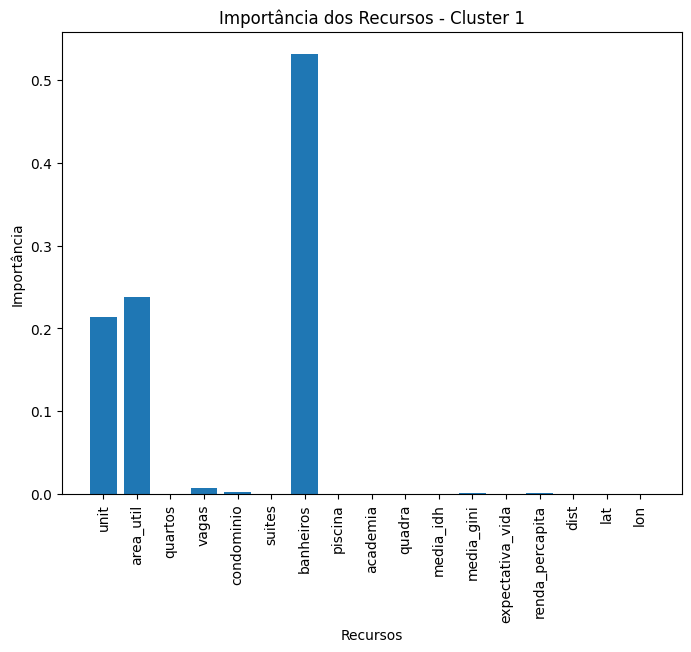

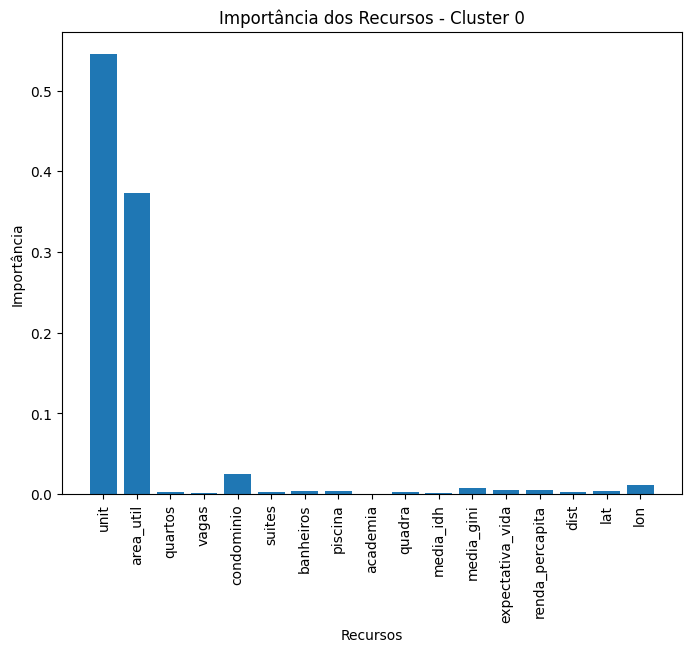

In [24]:
# Separar os dados por cluster
clusters = treated_df['cluster'].unique()

# Executar a análise de importância de recursos para cada cluster
for cluster in clusters:
    # Filtrar os dados para o cluster atual
    cluster_data = treated_df[treated_df['cluster'] == cluster]
    
    # Definir as variáveis independentes e dependentes
    X = cluster_data.drop(['valor_total', 'cluster'], axis=1)
    y = cluster_data['valor_total']
    
    # Criar o modelo XGBoost
    model = xgb.XGBRegressor()
    
    # Treinar o modelo
    model.fit(X, y)
    
    # Obter a importância dos recursos
    feature_importance = model.feature_importances_
    feature_names = X.columns
    
    # Plotar a importância dos recursos
    plt.figure(figsize=(8, 6))
    plt.bar(feature_names, feature_importance)
    plt.title(f'Importância dos Recursos - Cluster {cluster}')
    plt.xlabel('Recursos')
    plt.ylabel('Importância')
    plt.xticks(rotation=90)
    plt.show()